## Prompting

In [17]:
import json
import random

import matplotlib.pyplot as plt
import numpy as np

In [18]:
def vote_by_majority(responses):
    votes = dict()
    passed = dict()
    
    for response in responses:
        source = response[0]
        source = '\n'.join(
            [
                line for line in source.split('\n') 
                if not line.startswith('```') and not line.strip().startswith('def ')
            ])
        if source not in votes:
            passed[source] = response[1]['result'] == "passed"
            votes[source] = 0
        votes[source] += 1
    
    max_votes = max(votes.values())
    top_sources = [src for src, count in votes.items() if count == max_votes]
    chosen_source = random.choice(top_sources)
    
    return chosen_source, max_votes, passed[chosen_source]

def pass_at_any_for(responses_path):
    with open(responses_path) as f:
        benchmark_responses = json.load(f)
    
    passed_count = 0
    for id in benchmark_responses:
        source, votes, is_passed = vote_by_majority(benchmark_responses[id])
        if is_passed:
            passed_count += 1
    
    return passed_count


In [49]:
def pretty_print_results(benchmark, models):
    model_wise_results = list()
    for model in models:
        results = [
            pass_at_any_for(f'results/{benchmark}_{model}.json'),
            pass_at_any_for(f'results/{benchmark}_{model}_instruction.json'),
            pass_at_any_for(f'results/{benchmark}_{model}_rule.json'),
        ]
        print(model, '\t'.join(map(str, results)), sep='\t')
        model_wise_results.append(results)
    return model_wise_results

In [48]:
def load_and_visualize(benchmark, models, technique_wise_results):
    data1 = technique_wise_results[0]
    data2 = technique_wise_results[1]
    data3 = technique_wise_results[2]

    x = np.arange(len(models))  # label locations
    width = 0.25  # width of the bars

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, data1, width, label='Baseline', color='#7fc97f')
    bars2 = ax.bar(x, data2, width, label='Instruction', color='#beaed4')
    bars3 = ax.bar(x + width, data3, width, label='Rule', color='#fdc086')

    ax.set_xlabel('Model')
    ax.set_ylabel(r'\it{pass@any}')
    ax.set_title(benchmark + r' $\it{pass@any}$ by Model and Prompt')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.grid(True, axis='y', linestyle='--')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'results/figures/{benchmark}_prompts.png', dpi=300)

llama3	23	19	17
llama3.1	17	11	1
mistral-nemo	30	32	15
qwen2.5-coder	21	14	6


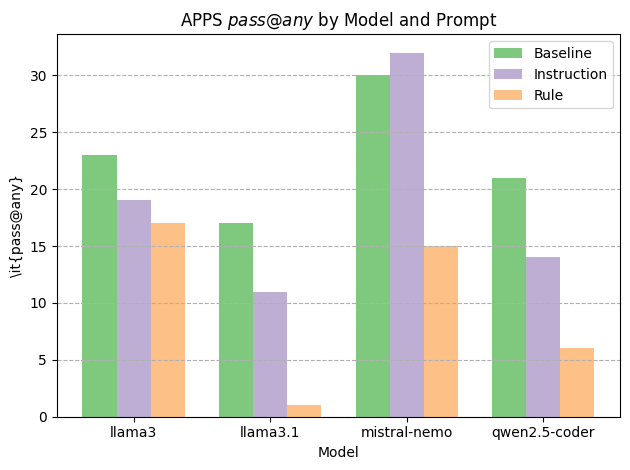

In [51]:
random.seed(42)

benchmark = 'APPS'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']

model_wise_results = pretty_print_results(benchmark, models)
technique_wise_results = [[model_wise_results[j][i] for j in range(4)] for i in range(3)]
load_and_visualize(benchmark, models, technique_wise_results)